## Friction surface analysis to water points

In [3]:
import rasterio as rio
from rasterio.plot import show
from osgeo import gdal
import numpy as np
import GOSTRocks
import os
import geopandas as gpd
import rasterstats
import GOSTRocks.rasterMisc as rMisc

import sys
sys.path.append('D:\\OneDrive\\Work\\WorldBank\\Assignments\\20211104_SSudanWaterSecurity\\Code\\INFRA_SAP-master\\\INFRA_SAP-master')
from infrasap import aggregator

In [4]:
indir ="D:\\OneDrive\\Work\\WorldBank\\Assignments\\20211104_SSudanWaterSecurity\\Data\\Theme1\\FrictionSurface\\Access_Raster\\Access_Raster\\tt_water_all.tif"

In [5]:
friction = rio.open(indir) 

In [6]:
friction

<open DatasetReader name='D:\OneDrive\Work\WorldBank\Assignments\20211104_SSudanWaterSecurity\Data\Theme1\FrictionSurface\Access_Raster\Access_Raster\tt_water_all.tif' mode='r'>

In [7]:
with rio.open(indir) as dataset:

    # Read the dataset's valid data mask as a ndarray.
    mask = dataset.dataset_mask()


In [8]:
data = friction.read()

In [9]:
lista = data.copy()

In [10]:
lista[np.where(lista <=12.5)] = 1
lista[np.where(lista >12.5)] = None 

In [11]:
with rio.open("D:\\OneDrive\\Work\\WorldBank\\Assignments\\20211104_SSudanWaterSecurity\\Data\\Theme1\\FrictionSurface\\Access_Raster\\Access_Raster\\tt_water_30minRT_mask.tif", 'w',
             driver= friction.driver,
             height = friction.height,
             width = friction.width,
             count = friction.count,
             crs = friction.crs,
             transform = friction.transform,
             dtype = data.dtype
)as dst:
    dst.write(lista)


In [12]:
friction_mask = rio.open("D:\\OneDrive\\Work\\WorldBank\\Assignments\\20211104_SSudanWaterSecurity\\Data\\Theme1\\FrictionSurface\\Access_Raster\\Access_Raster\\tt_water_30minRT_mask.tif")

In [13]:
pop = rio.open('D:\\OneDrive\\Work\\WorldBank\\Assignments\\20211104_SSudanWaterSecurity\\Data\\RawData\\Population\\Population\\SSD_population_v1_0_gridded.tif')

In [14]:
type(friction_mask.read(1))

numpy.ndarray

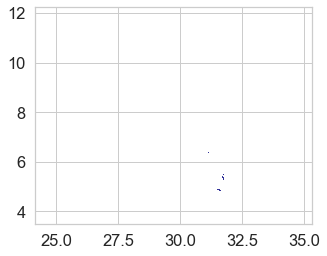

<AxesSubplot:>

In [15]:
show((friction_mask, 1), cmap='terrain')

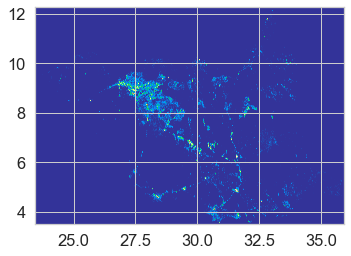

<AxesSubplot:>

In [16]:
show((pop, 1), cmap='terrain')

## Raster calculator: Population*Mask

In [17]:
outputdir = "D:\\OneDrive\\Work\\WorldBank\\Assignments\\20211104_SSudanWaterSecurity\\Data\\Theme1\\FrictionSurface\\Access_Raster\\Access_Raster\\tt_water_30minRT_mask_STD.tif"

In [18]:
# Make sure that both rasters have the exact same resolution, crs, and number of pixels
rMisc.standardizeInputRasters(friction_mask, pop, outputdir, data_type="C")

[array([[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]]),
 {'driver': 'GTiff',
  'dtype': 'float64',
  'nodata': None,
  'width': 15000,
  'height': 10546,
  'count': 1,
  'crs': CRS.from_epsg(4326),
  'transform': Affine(0.00083333333, 0.0, 23.441249922,
         0.0, -0.0008333333299829318, 12.281250152)}]

In [20]:
friction_mask_STD = rio.open(outputdir)

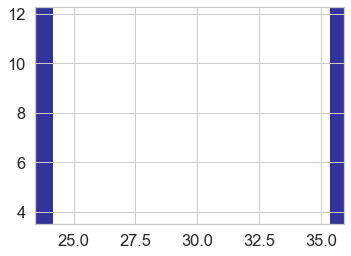

<AxesSubplot:>

In [21]:
show((friction_mask_STD, 1), cmap='terrain')

In [68]:
pop_close2water = pop.read(1)*friction_mask_STD.read(1)

In [69]:
pop_close2water[pop_close2water< 0]=0 # turning negative numbers to 0

In [73]:
with rio.open(r'D:\OneDrive\Work\WorldBank\Assignments\20211104_SSudanWaterSecurity\Data\Theme1\Pop\pop_inside30minRT2water_usingFrictionSurface2.tif', 'w',
             driver= pop.driver,
             height = pop.height,
             width = pop.width,
             count = pop.count,
             crs = pop.crs,
             transform = pop.transform,
             dtype = 'float64'
)as dst:
    dst.write(pop_close2water,1)


## Zonal Statistics

In [74]:
dist = gpd.read_file(r'D:\OneDrive\Work\WorldBank\Assignments\20211104_SSudanWaterSecurity\Data\RawData\AdminBoundaries\SS_ADM2.shp')

In [75]:
totalpop = rio.open(r'D:\OneDrive\Work\WorldBank\Assignments\20211104_SSudanWaterSecurity\Data\RawData\Population\Population\SSD_population_v1_0_gridded.tif')

In [76]:
pop30m2water= rio.open(r'D:\OneDrive\Work\WorldBank\Assignments\20211104_SSudanWaterSecurity\Data\Theme1\Pop\pop_inside30minRT2water_usingFrictionSurface2.tif')

### Zonal statistics for total population

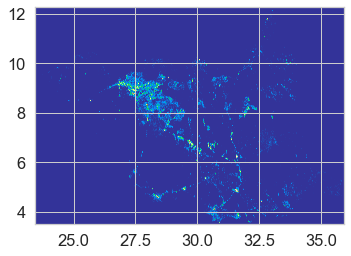

<AxesSubplot:>

In [77]:
show((totalpop, 1), cmap='terrain')

In [78]:
totalpop_Arr = totalpop.read(1)

In [79]:
totalpop_Arr[totalpop_Arr < 0] = 0

In [80]:
affine1 = totalpop.transform

In [81]:
sum_pop = rasterstats.zonal_stats(dist,totalpop_Arr,affine = affine1,
                                   stats = ['sum'])

C:\Users\glev2\anaconda3\envs\dreamenv\lib\site-packages\rasterstats\io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


In [82]:
sum_pop_numOnly = []
for i in sum_pop:
    sum_pop_numOnly.append(i['sum'])

In [83]:
dist['sum_popWP'] = sum_pop_numOnly

### Zonal statistics for population inside 30 min dist to water. 
calculated as 12.5 min each direction and 5 min at location for water extraction

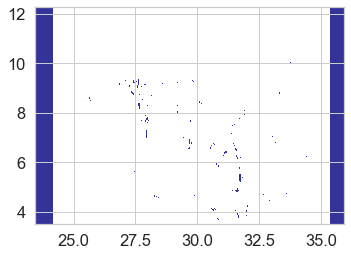

<AxesSubplot:>

In [84]:
show((pop30m2water, 1), cmap='terrain')

In [85]:
pop30m2water_Arr = pop30m2water.read(1)

In [86]:
pop30m2water_Arr[pop30m2water_Arr < 0] = 0

In [87]:
affine2 = pop30m2water.transform

In [88]:
sum_popWP_30m2water = rasterstats.zonal_stats(dist,pop30m2water_Arr,affine = affine2,
                                   stats = ['sum'])

In [89]:
sum_popWP_30m2water_numOnly = []
for i in sum_popWP_30m2water:
    sum_popWP_30m2water_numOnly.append(i['sum'])

In [140]:
sum_popWP_30m2water_numOnly

[438508.74410903454,
 212859.09484100342,
 81532.32378137112,
 88792.29048538208,
 130312.32362413406,
 205575.46415615082,
 24944.505546569824,
 28282.94225883484,
 73582.49301719666,
 97809.96899795532,
 71953.67899894714,
 26507.52328491211,
 76068.30011153221,
 53657.479290008545,
 53166.60048675537,
 24142.97658085823,
 174080.52539241314,
 0.0,
 39820.4590883255,
 44758.48959159851,
 80907.39716148376,
 33773.93397426605,
 0.0,
 91947.19893956184,
 142124.77064228058,
 133793.82858383004,
 59769.29325771332,
 212920.29448127747,
 142764.0745587349,
 16892.0560516119,
 44528.20225095749,
 113158.83323717117,
 93452.1889321804,
 22625.809336185455,
 207015.27225840092,
 59960.13400518894,
 43606.049409389496,
 128423.86393982172,
 0.0,
 5104.764409542084,
 20921.50685930252,
 44578.28847193718,
 60022.44160556793,
 20817.22105205059,
 43087.493806004524,
 None,
 155405.36974930763,
 0.0,
 17111.329524755478,
 25224.46461725235,
 39694.78482580185,
 31047.424527049065,
 18842.303726

In [141]:
dist['pin_30m2w'] = sum_popWP_30m2water_numOnly
dist['pin_30m2w'] = dist['pin_30m2w'].fillna(0)

### Calculate Pop outside of 30 min

In [142]:
dist['pout_30m2w'] = dist['sum_popWP']- dist['pin_30m2w']

### Calculate  Percentages

In [143]:
dist['ppin_30m2w'] = (dist['pin_30m2w']/dist['sum_popWP'])*100

In [144]:
dist['ppout_30m2w'] = (dist['pout_30m2w']/dist['sum_popWP'])*100

In [145]:
dist

,Shape_Leng,Shape_Area,ADM2_EN,ADM2_PCODE,ADM2_REF,ADM2ALT1EN,ADM2ALT2EN,ADM1_EN,ADM1_PCODE,ADM0_EN,...,RP100_he_1,RP100_buil,Area2,pop_no_ris,geometry,sum_popWP,pin_30m2w,pout_30m2w,ppin_30m2w,ppout_30m2w
0,6.425236,18611.507286,Juba,SS0101,None,None,None,Central Equatoria,SS01,South Sudan,...,0.062500,13960.0,18365.20,411950.646975,"POLYGON ((32.10224 5.36788, 32.09834 5.21346, ...",561713.296328,438508.744109,123204.552219,78.066292,21.933708
1,2.082643,2549.814924,Kajo-keji,SS0102,None,None,None,Central Equatoria,SS01,South Sudan,...,0.000000,9.0,2515.96,262816.482042,"POLYGON ((31.61854 4.02379, 31.69394 3.95754, ...",241027.162724,212859.094841,28168.067883,88.313322,11.686678
2,3.402761,3545.715110,Lainya,SS0103,None,None,None,Central Equatoria,SS01,South Sudan,...,0.000000,5.0,3501.75,116069.837670,"POLYGON ((31.18674 4.30480, 31.17532 4.25454, ...",108818.403997,81532.323781,27286.080215,74.925124,25.074876
3,2.069064,1326.493498,Morobo,SS0104,None,None,None,Central Equatoria,SS01,South Sudan,...,0.000000,34.0,1309.79,134373.942852,"POLYGON ((31.04738 3.81817, 31.09567 3.74048, ...",147859.408638,88792.290485,59067.118153,60.051837,39.948163
4,5.221777,10813.630464,Terekeka,SS0105,None,Terkeka,None,Central Equatoria,SS01,South Sudan,...,0.086957,2998.0,10673.80,89903.651139,"POLYGON ((31.02171 5.90953, 31.69732 5.87275, ...",224011.716785,130312.323624,93699.393161,58.172102,41.827898
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,3.220148,5786.475341,Mvolo,SS1006,None,None,None,Western Equatoria,SS10,South Sudan,...,0.000000,0.0,5721.79,44525.888734,"POLYGON ((30.12183 6.35244, 30.15537 6.23657, ...",62352.973156,36485.876675,25867.096482,58.515055,41.484945
74,3.862937,9318.009503,Nagero,SS1007,None,None,None,Western Equatoria,SS10,South Sudan,...,0.000000,0.0,9267.80,11075.192596,"POLYGON ((28.03236 6.74766, 28.04826 6.73971, ...",12278.443665,9374.281474,2904.162190,76.347473,23.652527
75,5.672132,6529.697021,Nzara,SS1008,None,None,None,Western Equatoria,SS10,South Sudan,...,0.000000,0.0,6484.18,76253.676093,"POLYGON ((28.52396 6.25181, 28.57275 6.07495, ...",90158.387460,66900.285148,23258.102312,74.203063,25.796937
76,5.860083,12619.589011,Tambura,SS1009,None,None,None,Western Equatoria,SS10,South Sudan,...,0.071429,0.0,12577.20,64233.888647,"POLYGON ((27.06807 6.65988, 27.07929 6.54093, ...",11836.336944,9676.688197,2159.648747,81.754078,18.245922


Export shp file of districts with appended data

In [147]:
dist.to_file(r'D:\OneDrive\Work\WorldBank\Assignments\20211104_SSudanWaterSecurity\Data\output\Pop_WaterAccess\Results\Adm2_wPop30minfromWater_FrictionSurface_Final.shp')

C:\Users\glev2\AppData\Local\Temp/ipykernel_8428/532941041.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  dist.to_file(r'D:\OneDrive\Work\WorldBank\Assignments\20211104_SSudanWaterSecurity\Data\output\Pop_WaterAccess\Results\Adm2_wPop30minfromWater_FrictionSurface_Final.shp')


## Create Friction Surface Raster time calculation for RT to water

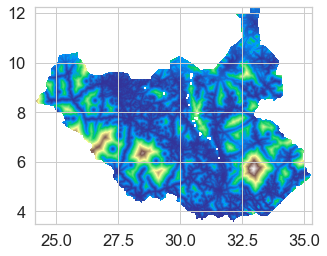

<AxesSubplot:>

In [100]:
show((friction, 1), cmap='terrain')

In [101]:
frictionRT = friction.read(1)

In [112]:
frictionRT = frictionRT*2 -5

In [113]:
frictionRT

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [115]:
with rio.open(r'D:\OneDrive\Work\WorldBank\Assignments\20211104_SSudanWaterSecurity\Data\Theme1\FrictionSurface\Access_Raster\Access_Raster\tt_water_allRT.tif', 'w',
             driver= friction.driver,
             height = friction.height,
             width = friction.width,
             count = friction.count,
             crs = friction.crs,
             transform = friction.transform,
             dtype = 'float64'
)as dst:
    dst.write(frictionRT,1)